## Step 1: Imports & Setup

In [1]:
# --------------------------
# Step 1: Import All Libraries (Consolidated)
# --------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import (
    resnet18, resnet50, convnext_tiny, vit_b_16, vit_l_16, swin_t, swin_b,
    ResNet18_Weights, ResNet50_Weights, ConvNeXt_Tiny_Weights,
    ViT_B_16_Weights, ViT_L_16_Weights, Swin_T_Weights, Swin_B_Weights
)
from torchinfo import summary
from tqdm.auto import tqdm

# Device configuration (single definition)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Step 2: Define your dataset class

In [2]:
# Step 2: AQIDataset (Unchanged, but kept for completeness)
# --------------------------
class AQIDataset(Dataset):
    def __init__(self, images_dir, labels_csv, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_csv)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        img_name = row['Filename']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Retrieve 7 pollutant labels (match training: 'PM25' not 'PM2.5')
        labels = row[['NO2']].values.astype('float32')
        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

## Step 3: Prepare datasets and dataloaders

In [3]:
# Data Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Read labels.csv
labels_df = pd.read_csv('all_timeslot_cleaned.csv')

# Split into train and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42, shuffle=True)

# Save temporary csv for convenience
train_df.to_csv('train_labels_NO2.csv', index=False)
val_df.to_csv('val_labels_NO2.csv', index=False)

# Prepare Dataset objects
train_dataset = AQIDataset('all_images/', 'train_labels_NO2.csv', transform=data_transforms)
print(f'Len of training: {len(train_dataset)}')
val_dataset = AQIDataset('all_images/', 'val_labels_NO2.csv', transform=data_transforms)
print(f'Len of validation: {len(val_dataset)}')
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Len of training: 18550
Len of validation: 2062


## Step 4: Define your Model

In [4]:
# Step 3: Backbone & AQINet (Match Training Exactly)
# --------------------------
_BACKBONES = {
    "resnet18":  ("resnet", resnet18, ResNet18_Weights),
    "resnet50":  ("resnet", resnet50, ResNet50_Weights),
    "convnext_tiny": ("convnext", convnext_tiny, ConvNeXt_Tiny_Weights),
    "vit_b_16":  ("vit",  vit_b_16, ViT_B_16_Weights),
    "vit_l_16":  ("vit",  vit_l_16, ViT_L_16_Weights),
    "swin_t":    ("swin", swin_t, Swin_T_Weights),
    "swin_b":    ("swin", swin_b, Swin_B_Weights),
}

def _make_encoder(name: str, pretrained: bool = True):
    """Build encoder (exact copy from training)"""
    if name not in _BACKBONES:
        raise ValueError(f"Unknown backbone '{name}'. Choose from: {list(_BACKBONES.keys())}")

    family, ctor, weights_enum = _BACKBONES[name]
    weights = weights_enum.DEFAULT if pretrained else None
    m = ctor(weights=weights)

    if family == "resnet":
        feat_dim = m.fc.in_features
        m.fc = nn.Identity()
        encoder = m
    elif family == "convnext":
        # Critical: ConvNeXt encoder returns (N, 768, H, W) (no GAP here—GAP is in AQINet's encoder!)
        # This fixes the feature map dimension mismatch for CAM
        feat_dim = 768
        encoder = m.features  # ONLY the feature extractor (no AdaptiveAvgPool2d/Flatten)
    elif family == "vit":
        feat_dim = m.heads.head.in_features
        m.heads = nn.Identity()
        encoder = m
    elif family == "swin":
        feat_dim = m.head.in_features
        m.head = nn.Identity()
        encoder = m
    else:
        raise RuntimeError("Unhandled backbone family.")

    return encoder, feat_dim

class AQINet(nn.Module):
    """AQINet (exact copy from training)"""
    def __init__(self,
                 output_dim: int = 1,
                 backbone: str = "vit_b_16",
                 pretrained: bool = True,
                 head_hidden: int = 256,
                 dropout: float = 0.2):
        super().__init__()
        self.backbone_name = backbone
        self.encoder, feat_dim = _make_encoder(backbone, pretrained)

        # For ConvNeXt: Add GAP to match other backbones' (N, feat_dim) output
        if backbone == "convnext_tiny":
            self.encoder = nn.Sequential(
                self.encoder,  # ConvNeXt features (N, 768, 7, 7)
                nn.AdaptiveAvgPool2d(1),  # (N, 768, 1, 1)
                nn.Flatten(1)  # (N, 768)
            )

        self.head = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, head_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, output_dim)
        )

    def forward(self, img):
        feats = self.encoder(img)
        if feats.dim() == 4:
            feats = feats.squeeze(-1).squeeze(-1)
        return self.head(feats)

In [5]:
# Examples
# -----------------------------
# ViT base 16x16
# model = AQINet(backbone="vit_b_16").to(device)

# Swin-T
# model = AQINet(backbone="swin_t").to(device)

# ResNet-50
model = AQINet(backbone="resnet18").to(device)

# ConvNeXt-Tiny
# model = AQINet(backbone="convnext_tiny").to(device)
# 

In [6]:
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable}/{total}")
summary(model.to(device))

Device: cuda
Trainable params: 11309121/11309121


Layer (type:depth-idx)                        Param #
AQINet                                        --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   230,144
│    │    └─BasicBlock: 3-4                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   919,040
│    │    └─BasicBlock: 3-6                   1,180,672
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   3,673,088
│    │    └─BasicBlock: 3-8                   4,720,640
│    └─AdaptiveA

## Step 5: Define Loss and Optimizer

In [7]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


## Step 6: Training Loop

In [8]:
import numpy as np
import torch
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

num_epochs = 50
best_model_path = "best_single_image_model_NO2.pth"
# Initialize tracking variables
best_val_r2 = -np.inf
# columns = ['VOC', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10', 'O3']
columns = ['NO2']
num_pollutants = len(columns)

# History dictionary to track metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'mae': [],
    'rmse': [],
    'r2': [],
    'per_pollutant_r2': [[] for _ in range(num_pollutants)]
}

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    # ------------------------ Training ------------------------
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item() * images.size(0)
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # ------------------------ Validation ------------------------
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate loss and predictions
            val_loss += loss.item() * images.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    # Convert to NumPy arrays for metric calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Store metrics
    history['mae'].append(mae)
    history['rmse'].append(rmse)
    history['r2'].append(r2)

    # Print epoch summary
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    # Per-pollutant R² scores
    print("Per-pollutant R² Scores:")
    for i, name in enumerate(columns):
        pollutant_r2 = r2_score(y_true[:, i], y_pred[:, i])
        history['per_pollutant_r2'][i].append(pollutant_r2)
        print(f"  {name}: {pollutant_r2:.4f}")

    # Model checkpointing - save if current model is better
    if r2 > best_val_r2:
        best_val_r2 = r2
        # torch.save({
        #     'epoch': epoch + 1,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'best_r2': best_val_r2,
        #     'loss': criterion
        # }, best_model_path)
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved best model (R²: {best_val_r2:.4f})")

print('\n***Training Complete***')
print(f"Best Validation R²: {best_val_r2:.4f}")


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch [1/50]
Train Loss: 858.4552 | Val Loss: 93.7559
MAE: 7.6892 | RMSE: 9.6828 | R²: 0.4085
Per-pollutant R² Scores:
  NO2: 0.4085
✅ Saved best model (R²: 0.4085)

Epoch [2/50]
Train Loss: 57.9942 | Val Loss: 30.2257
MAE: 4.2235 | RMSE: 5.4978 | R²: 0.8093
Per-pollutant R² Scores:
  NO2: 0.8093
✅ Saved best model (R²: 0.8093)

Epoch [3/50]
Train Loss: 34.4191 | Val Loss: 23.1691
MAE: 3.4752 | RMSE: 4.8134 | R²: 0.8538
Per-pollutant R² Scores:
  NO2: 0.8538
✅ Saved best model (R²: 0.8538)

Epoch [4/50]
Train Loss: 26.6227 | Val Loss: 21.0133
MAE: 3.3358 | RMSE: 4.5840 | R²: 0.8674
Per-pollutant R² Scores:
  NO2: 0.8674
✅ Saved best model (R²: 0.8674)

Epoch [5/50]
Train Loss: 21.4923 | Val Loss: 21.8608
MAE: 3.5088 | RMSE: 4.6755 | R²: 0.8621
Per-pollutant R² Scores:
  NO2: 0.8621

Epoch [6/50]
Train Loss: 18.5981 | Val Loss: 20.4845
MAE: 3.2501 | RMSE: 4.5260 | R²: 0.8708
Per-pollutant R² Scores:
  NO2: 0.8708
✅ Saved best model (R²: 0.8708)

Epoch [7/50]
Train Loss: 17.7136 | Val L

C:\Users\User\AppData\Local\Temp\ipykernel_3432\2986401139.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("best_single_image_model_NO2.pth", map_lo

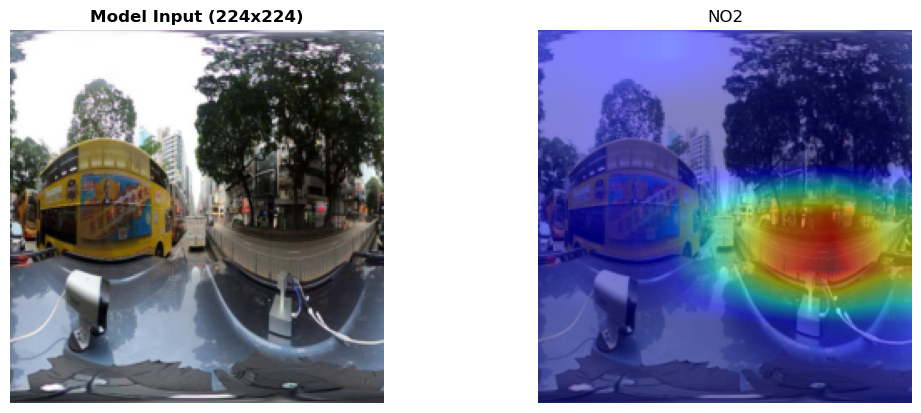

In [10]:
# ========= Grad-CAM helper (ResNet18/50 + ConvNeXt-Tiny) =========
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

def get_cam_target_layer(aqinet_model: nn.Module, backbone_name: str) -> nn.Module:
    """
    Returns the feature module to hook BEFORE any GAP/Flatten in AQINet.encoder.
    Supports: 'resnet18', 'resnet50', 'convnext_tiny'
    """
    name = backbone_name.lower()
    enc = aqinet_model.encoder

    if name in ("resnet18", "resnet50"):
        # encoder is the whole resnet with fc=Identity
        # last conv block is layer4[-1]
        return enc.layer4[-1]
    elif name == "convnext_tiny":
        # encoder is Sequential(features, GAP, Flatten)
        # find the ConvNeXt feature extractor robustly
        for m in enc.children():
            # ConvNeXt features module has attribute 'stages' in torchvision
            if hasattr(m, "stages") or m.__class__.__name__.lower().startswith("convnext"):
                return m
        # Fallback to first child if structure differs
        return list(enc.children())[0]
    else:
        raise NotImplementedError(
            f"Grad-CAM target auto-pick not implemented for backbone='{backbone_name}'. "
            "ViT/Swin require transformer-aware CAM."
        )

class GradCAM:
    """
    Generic Grad-CAM for conv backbones. No hard-coded shapes:
    - caches feature maps at target layer forward
    - caches gradients at target layer backward
    - produces a (H_in, W_in) heatmap via bilinear upsampling
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module, out_size: Tuple[int, int]=(224, 224)):
        self.model = model.eval()
        self.target_layer = target_layer
        self.out_size = out_size

        self._fmap = None   # (N, C, H, W)
        self._grad = None   # (N, C, H, W)
        self._handles = []
        self._handles.append(self.target_layer.register_forward_hook(self._fhook))
        self._handles.append(self.target_layer.register_full_backward_hook(self._bhook))

    def _fhook(self, module, inputs, output):
        self._fmap = output

    def _bhook(self, module, grad_input, grad_output):
        self._grad = grad_output[0]

    def __call__(self, x: torch.Tensor, target_index: int) -> torch.Tensor:
        """
        x: (1,3,H,W) input tensor
        target_index: which logit/regression output to explain (int)
        returns: (H_in, W_in) heatmap in [0,1], torch.float32 CPU tensor
        """
        # Clear stale grads
        for p in self.model.parameters():
            if p.grad is not None:
                p.grad = None

        # Forward/backward
        y = self.model(x)              # (1, D)
        score = y[0, target_index]
        score.backward()

        if self._fmap is None or self._grad is None:
            raise RuntimeError("Hooks did not capture fmap/grad. Check target layer.")

        # Expect feature maps with spatial dims
        if self._fmap.dim() != 4:
            raise RuntimeError(f"Target layer output must be 4D (N,C,H,W); got {self._fmap.shape}")

        # Grad-CAM weights: GAP over spatial dims for each channel
        # shapes: fmap=(1,C,H,W), grad=(1,C,H,W) -> weights=(C,)
        weights = F.adaptive_avg_pool2d(self._grad, 1).squeeze(0).squeeze(-1).squeeze(-1)  # (C,)
        fmap = self._fmap.squeeze(0)  # (C,H,W)

        # Weighted sum over channels -> (H,W)
        cam = torch.sum(weights[:, None, None] * fmap, dim=0)
        cam = F.relu(cam)

        # Normalize → upsample → normalize again for numerical stability
        if cam.max() <= 0:
            heat = torch.zeros(self.out_size, dtype=torch.float32, device=cam.device)
        else:
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            heat = F.interpolate(
                cam[None, None], size=self.out_size, mode="bilinear", align_corners=False
            ).squeeze(0).squeeze(0)
            heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

        return heat.detach().cpu().numpy()

    def close(self):
        for h in self._handles:
            h.remove()
        self._handles = []



# --------------------------
# Step 5: Load Trained Model (ConvNeXt-Tiny)
# --------------------------
# Initialize AQINet with the SAME backbone as training (convnext_tiny)
model = AQINet(
    backbone="resnet18",  # Critical: Must match training!
    output_dim=1,
    pretrained=True,
    head_hidden=256,
    dropout=0.2
).to(device)

# Load trained weights (safe, no UnpicklingError because we saved only state_dict)
state = torch.load("best_single_image_model_NO2.pth", map_location=device)
model.load_state_dict(state, strict=False)  # only if strict=True fails
# --------------------------
# Step 6: Select CORRECT Target Layer (ConvNeXt-Specific)
# --------------------------
# For ConvNeXt-Tiny: Target layer is the RAW feature extractor (before GAP in AQINet)
# Get the original ConvNeXt features (m.features) from AQINet's encoder
# AQINet's encoder for ConvNeXt is: [ConvNeXt.features, AdaptiveAvgPool2d, Flatten]
# Option A (robust): use the helper you already defined
target_layer = get_cam_target_layer(model, backbone_name="resnet18")
cam = GradCAM(model, target_layer, out_size=(224, 224))
# Option B (your original indexing, if you prefer):
# target_layer = model.encoder[0]
# cam = GradCAM(model, target_layer, out_size=(224, 224))


# --------------------------
# Step 7: Image Preprocessing (MATCH Training!)
# --------------------------
# Training used NO normalization—so CAM must use NO normalization!
# (Critical fix: Your training transform had no Normalize, but CAM did—caused mismatched inputs)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Same as training
    transforms.ToTensor()           # Same as training (scales to 0-1, no normalization)
])

# Load and preprocess the image
image_path = "output_frames_20250528/image202505280001.jpg"  # Replace with your image path
img_original = Image.open(image_path).convert('RGB')
img_224 = transform(img_original).unsqueeze(0).to(device)  # Add batch dim: (1,3,224,224)

# Convert tensor back to PIL image for plotting (no need to invert normalization)
# ToTensor() scales to 0-1 → multiply by 255 to get 0-255 (standard for images)
img_224_plot = (img_224.squeeze().cpu().numpy() * 255).astype(np.uint8)
img_224_plot = np.transpose(img_224_plot, (1, 2, 0))  # (C,H,W) → (H,W,C) for plotting


# --------------------------
# Step 8: Generate Heatmaps & Visualize
# --------------------------
pollutant_names = ['NO2']

# Generate 1 heatmap per pollutant (7 total)
heatmaps_224 = [cam(img_224, dim) for dim in range(len(pollutant_names))]

# Plot results (all 224x224, aligned with model input)
plt.figure(figsize=(16, 12))

# Show model input (224x224, exactly what the model sees)
plt.subplot(3, 3, 1)
plt.imshow(img_224_plot)
plt.title("Model Input (224x224)", fontsize=12, fontweight='bold')
plt.axis('off')

# Show heatmap for each pollutant
for i in range(len(pollutant_names)):
    plt.subplot(3, 3, i + 2)
    plt.imshow(img_224_plot)  # Base image (no color distortion)
    # Overlay heatmap (red = regions that increase pollutant prediction)
    plt.imshow(heatmaps_224[i], cmap='jet', alpha=0.5)
    plt.title(f"{pollutant_names[i]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Visualization

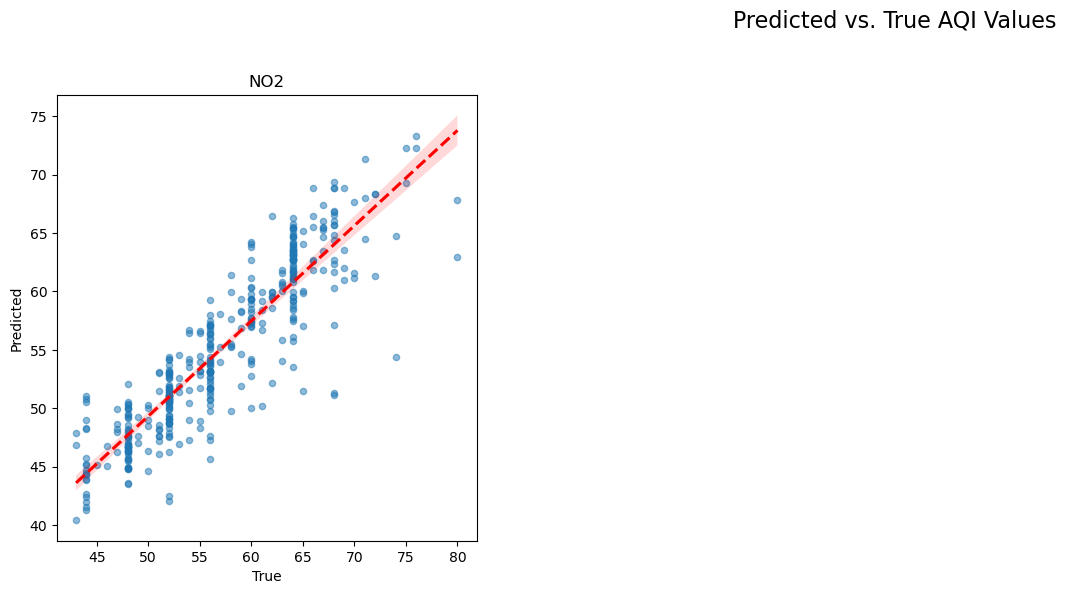

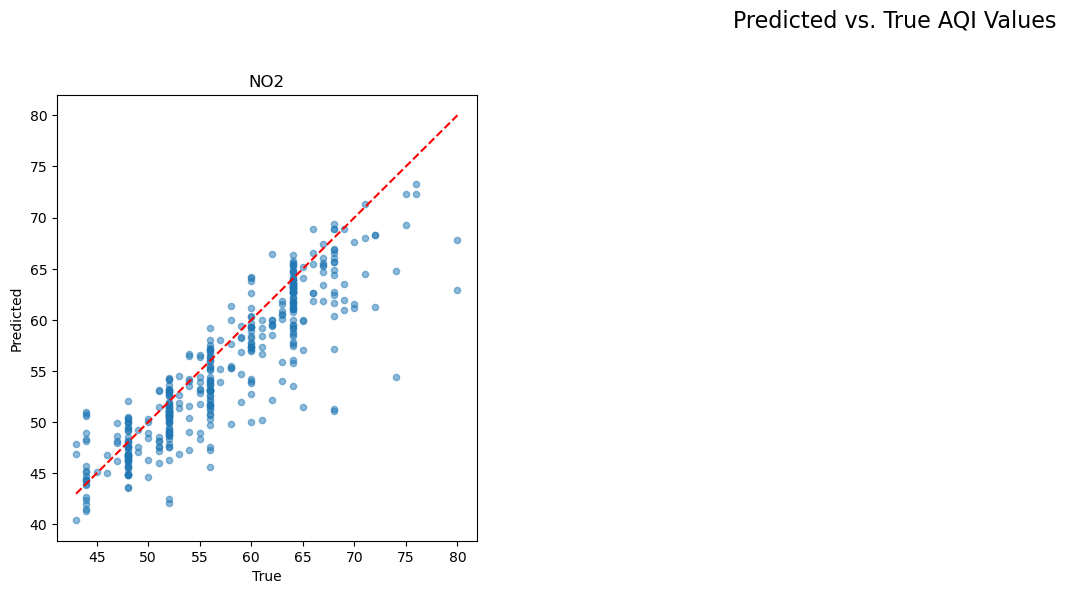

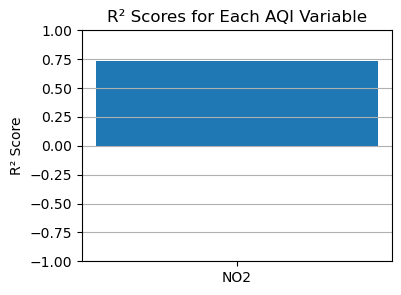

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['NO2']
n_vars = len(pollutants)

plt.figure(figsize=(18, 10))
for i in range(n_vars):
    plt.subplot(2, 4, i+1)
    # Use regplot for scatter and regression line
    sns.regplot(x=y_true[:, i], y=y_pred[:, i], scatter_kws={'alpha': 0.5, 's': 20}, line_kws={'color': 'red', 'linestyle': '--'})
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(pollutants[i])
plt.tight_layout()
plt.suptitle("Predicted vs. True AQI Values", fontsize=16, y=1.05)
plt.show()

plt.figure(figsize=(18, 10))
for i in range(n_vars):
    plt.subplot(2, 4, i+1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5, s=20)
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
    [y_true[:, i].min(), y_true[:, i].max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(pollutants[i])
plt.tight_layout()
plt.suptitle("Predicted vs. True AQI Values", fontsize=16, y=1.05)
plt.show()

from sklearn.metrics import r2_score
r2_scores = [r2_score(y_true[:, i], y_pred[:, i]) for i in range(n_vars)]
plt.figure(figsize=(4, 3))
plt.bar(pollutants, r2_scores)
plt.ylabel("R² Score")
plt.title("R² Scores for Each AQI Variable")
plt.ylim(-1, 1)
plt.grid(axis='y')
plt.show()



## Step 7: Save your trained model

In [19]:
torch.save(model.state_dict(), 'best_single_image_model_NO2.pth')
print('Model saved successfully.')


Model saved successfully.


## Step 8: Prediction function & Demo

In [10]:
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms

# -------- settings --------
input_path = Path("YauTsingMong/")   # single image OR folder
output_csv = "YauTsingMong_NO2.csv"
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# ensure model ready
# ResNet-50
model = AQINet(backbone="resnet18").to(device)
# Load trained weights (safe, no UnpicklingError because we saved only state_dict)
state = torch.load("best_single_image_model_NO2.pth", map_location=device, weights_only=True)
model.load_state_dict(state, strict=False)  # only if strict=True fails
model.eval()

# same transform as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def predict_aqi(image_path, model, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).cpu().numpy()[0]

    return {
        "NO2": output[0],
    }

def _list_images(folder: Path):
    return sorted(
        [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in valid_exts],
        key=lambda p: p.name
    )

# -------- run --------
if input_path.is_file():
    pred = predict_aqi(str(input_path), model, device)
    print(f"\nPredicted AQI values for {input_path.name}:")
    for k, v in pred.items():
        print(f"  {k}: {v:.3f}")

elif input_path.is_dir():
    images = _list_images(input_path)
    if not images:
        raise ValueError(f"No valid images found in {input_path}")

    rows = []
    for img_path in tqdm(images, desc="Inferring"):
        pred = predict_aqi(str(img_path), model, device)
        print(f"\n{img_path.name}:")
        for k, v in pred.items():
            print(f"  {k}: {v:.3f}")
        row = {"Filename": img_path.name}
        row.update(pred)
        rows.append(row)

    df = pd.DataFrame(rows, columns=["Filename", "NO2"])
    df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"\nSaved predictions to: {output_csv}")


else:
    raise FileNotFoundError(f"Path not found: {input_path}")


Inferring:   0%|          | 0/15313 [00:00<?, ?it/s]


0_114.155583_22.32122_1708.jpg:
  NO2: 63.930

10000_114.162297_22.322854_1707.jpg:
  NO2: 52.110

10001_114.162389_22.322789_1707.jpg:
  NO2: 58.471

10002_114.16245_22.322744_1707.jpg:
  NO2: 53.205

10003_114.162547_22.322672_1707.jpg:
  NO2: 52.663

10004_114.162618_22.322616_1707.jpg:
  NO2: 55.676

10005_114.170731_22.303207_1403.jpg:
  NO2: 59.417

10006_114.174095_22.307108_1707.jpg:
  NO2: 61.807

10007_114.169774_22.312886_1707.jpg:
  NO2: 50.368

10008_114.169875_22.312902_1707.jpg:
  NO2: 54.380

10009_114.16998_22.312917_1707.jpg:
  NO2: 56.058

1000_114.166354_22.303694_1403.jpg:
  NO2: 50.503

10010_114.18292_22.30343_1708.jpg:
  NO2: 56.450

10011_114.182943_22.303325_1708.jpg:
  NO2: 54.517

10012_114.182965_22.303224_1708.jpg:
  NO2: 48.421

10013_114.182988_22.30308_1708.jpg:
  NO2: 50.023

10014_114.182996_22.302923_1708.jpg:
  NO2: 54.191

10015_114.179586_22.301709_1708.jpg:
  NO2: 54.306

10016_114.169813_22.308757_1707.jpg:
  NO2: 61.182

10017_114.169713_22.30